In [1]:
import torch
from torch.utils.data import DataLoader
from step3_dataset import CervicalDataset, get_transforms
import segmentation_models_pytorch as smp

# 0. 경로 및 하이퍼파라미터 설정
DATA_DIR = 'final_preprocessed'
TRAIN_TXT = 'train_patients.txt'
VAL_TXT = 'val_patients.txt'
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\smc\anaconda3\envs\torch_cu13\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 데이터 불러오기

In [2]:
# 1. 데이터셋 및 로더 생성
# 학습용
train_ds = CervicalDataset(
    patient_list_file=TRAIN_TXT, 
    data_dir=DATA_DIR, 
    transform=get_transforms('train')
)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# 검증용
val_ds = CervicalDataset(
    patient_list_file=VAL_TXT, 
    data_dir=DATA_DIR, 
    transform=get_transforms('val')
)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# 2. 테스트 확인 (제대로 나오는지 딱 한 번만 출력)
print(f"🚀 학습 장치: {DEVICE}")
for imgs, masks in train_loader:
    print(f"✅ 이미지 배치 형태: {imgs.shape}") # [32, 2, 224, 224] (2채널 확인!)
    print(f"✅ 마스크 배치 형태: {masks.shape}") # [32, 224, 224]
    break

# 3. 모델 정의 (2채널 입력 설정)
model = smp.Unet(
    encoder_name="resnet34", 
    encoder_weights="imagenet", 
    in_channels=2, # 이미지 + Z-position
    classes=8      # C1~C7 + 배경
).to(DEVICE)

print("✅ 모델 준비 완료!")

c:\Users\smc\anaconda3\envs\torch_cu13\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


🧠 train_patients.txt 데이터를 RAM에 로딩 중...


100%|██████████| 69/69 [00:01<00:00, 52.06it/s]


✅ 로딩 완료! (환자 수: 69)
🧠 val_patients.txt 데이터를 RAM에 로딩 중...


100%|██████████| 18/18 [00:00<00:00, 54.10it/s]


✅ 로딩 완료! (환자 수: 18)
🚀 학습 장치: cuda
✅ 이미지 배치 형태: torch.Size([32, 2, 224, 224])
✅ 마스크 배치 형태: torch.Size([32, 224, 224])
✅ 모델 준비 완료!


In [4]:
# step4_train.ipynb 의 데이터 로더 확인 셀
for imgs, masks in train_loader:
    print(f"이미지 형태: {imgs.shape}")
    print(f"마스크 형태: {masks.shape}")
    
    # ⭐ 여기가 핵심: 0~7까지만 있어야 함
    unique_vals = torch.unique(masks)
    print(f"현재 배치에 포함된 라벨들: {unique_vals.tolist()}")
    
    if max(unique_vals) > 7:
        print("🚨 비상! 아직도 8 이상의 숫자가 들어있습니다. Dataset 코드를 다시 보세요!")
    else:
        print("✅ 클린합니다. 이제 모델을 생성해도 좋습니다.")
    break

이미지 형태: torch.Size([32, 2, 224, 224])
마스크 형태: torch.Size([32, 224, 224])
현재 배치에 포함된 라벨들: [0, 1, 2, 3, 4, 5, 6, 7]
✅ 클린합니다. 이제 모델을 생성해도 좋습니다.


## train / val

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import os

# 우리가 만든 모듈 불러오기
from step3_dataset import CervicalDataset, get_transforms
import segmentation_models_pytorch as smp

# --- [1. 하이퍼파라미터 설정] ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 50
DATA_DIR = 'final_preprocessed'
SAVE_DIR = './checkpoints'
os.makedirs(SAVE_DIR, exist_ok=True)

# --- [2. 데이터 로더 준비] ---
train_ds = CervicalDataset('train_patients.txt', DATA_DIR, transform=get_transforms('train'))
val_ds = CervicalDataset('val_patients.txt', DATA_DIR, transform=get_transforms('val'))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# --- [3. 모델 정의 (2채널 입력)] ---
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=2,  # 이미지(1) + Z-position(1)
    classes=8       # 배경 + C1~C7
).to(DEVICE)

# --- [4. 손실함수 및 최적화 도구] ---
# DiceLoss와 CrossEntropy를 합쳐서 사용합니다.
criterion_dice = smp.losses.DiceLoss(mode='multiclass')
criterion_ce = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

# --- [5. 학습 루프 정의] ---
best_val_loss = float('inf')
patience = 10  # 성능 개선이 10번 연속 없으면 종료
counter = 0    # 개선 없는 횟수를 세는 카운터

for epoch in range(EPOCHS):
    # [1] Train Phase (동일)
    model.train()
    train_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    for imgs, masks in pbar:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE).long()
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = 0.5 * criterion_dice(outputs, masks) + 0.5 * criterion_ce(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    avg_train_loss = train_loss / len(train_loader)

    # [2] Validation Phase (동일)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE).long()
            outputs = model(imgs)
            loss = 0.5 * criterion_dice(outputs, masks) + 0.5 * criterion_ce(outputs, masks)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"▶ Epoch {epoch+1} 완료 | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # [3] EarlyStopping & 모델 저장 로직
    scheduler.step(avg_val_loss) # 성능 안 오르면 LR 낮추기
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), os.path.join(SAVE_DIR, 'best_model.pth'))
        print(f"⭐ Best Model 갱신 및 저장 완료!")
        counter = 0  # 개선되었으니 카운터 초기화
    else:
        counter += 1 # 개선 안 됨
        print(f"⚠️ 개선 없음 (카운터: {counter}/{patience})")
        
    if counter >= patience:
        print(f"🛑 {patience}번 동안 개선이 없어 학습을 조기에 종료합니다.")
        break

print("🎊 학습이 종료되었습니다!")

🧠 train_patients.txt 데이터를 RAM에 로딩 중...


100%|██████████| 69/69 [00:01<00:00, 53.78it/s]


✅ 로딩 완료! (환자 수: 69)
🧠 val_patients.txt 데이터를 RAM에 로딩 중...


100%|██████████| 18/18 [00:00<00:00, 51.09it/s]


✅ 로딩 완료! (환자 수: 18)


Epoch 1/50 [Train]: 100%|██████████| 276/276 [00:44<00:00,  6.24it/s, loss=0.6320]


▶ Epoch 1 완료 | Train Loss: 0.9563 | Val Loss: 0.3756
⭐ Best Model 갱신 및 저장 완료!


Epoch 2/50 [Train]: 100%|██████████| 276/276 [00:44<00:00,  6.14it/s, loss=0.4373]


▶ Epoch 2 완료 | Train Loss: 0.5268 | Val Loss: 0.2075
⭐ Best Model 갱신 및 저장 완료!


Epoch 3/50 [Train]: 100%|██████████| 276/276 [00:44<00:00,  6.16it/s, loss=0.2784]


▶ Epoch 3 완료 | Train Loss: 0.3742 | Val Loss: 0.1575
⭐ Best Model 갱신 및 저장 완료!


Epoch 4/50 [Train]: 100%|██████████| 276/276 [00:45<00:00,  6.12it/s, loss=0.2332]


▶ Epoch 4 완료 | Train Loss: 0.2374 | Val Loss: 0.1386
⭐ Best Model 갱신 및 저장 완료!


Epoch 5/50 [Train]: 100%|██████████| 276/276 [00:45<00:00,  6.09it/s, loss=0.1782]


▶ Epoch 5 완료 | Train Loss: 0.1691 | Val Loss: 0.0972
⭐ Best Model 갱신 및 저장 완료!


Epoch 6/50 [Train]: 100%|██████████| 276/276 [00:45<00:00,  6.09it/s, loss=0.0967]


▶ Epoch 6 완료 | Train Loss: 0.1328 | Val Loss: 0.0851
⭐ Best Model 갱신 및 저장 완료!


Epoch 7/50 [Train]: 100%|██████████| 276/276 [00:44<00:00,  6.14it/s, loss=0.1042]


▶ Epoch 7 완료 | Train Loss: 0.1128 | Val Loss: 0.0820
⭐ Best Model 갱신 및 저장 완료!


Epoch 8/50 [Train]: 100%|██████████| 276/276 [00:44<00:00,  6.19it/s, loss=0.1092]


▶ Epoch 8 완료 | Train Loss: 0.1011 | Val Loss: 0.0727
⭐ Best Model 갱신 및 저장 완료!


Epoch 9/50 [Train]: 100%|██████████| 276/276 [00:45<00:00,  6.11it/s, loss=0.0700]


▶ Epoch 9 완료 | Train Loss: 0.0885 | Val Loss: 0.0698
⭐ Best Model 갱신 및 저장 완료!


Epoch 10/50 [Train]: 100%|██████████| 276/276 [00:44<00:00,  6.22it/s, loss=0.0750]


▶ Epoch 10 완료 | Train Loss: 0.0792 | Val Loss: 0.0660
⭐ Best Model 갱신 및 저장 완료!


Epoch 11/50 [Train]: 100%|██████████| 276/276 [00:45<00:00,  6.08it/s, loss=0.0686]


▶ Epoch 11 완료 | Train Loss: 0.0752 | Val Loss: 0.0631
⭐ Best Model 갱신 및 저장 완료!


Epoch 12/50 [Train]: 100%|██████████| 276/276 [00:45<00:00,  6.04it/s, loss=0.0635]


▶ Epoch 12 완료 | Train Loss: 0.0695 | Val Loss: 0.0721
⚠️ 개선 없음 (카운터: 1/10)


Epoch 13/50 [Train]: 100%|██████████| 276/276 [00:45<00:00,  6.09it/s, loss=0.0545]


▶ Epoch 13 완료 | Train Loss: 0.0670 | Val Loss: 0.0588
⭐ Best Model 갱신 및 저장 완료!


Epoch 14/50 [Train]: 100%|██████████| 276/276 [00:46<00:00,  5.95it/s, loss=0.0556]


▶ Epoch 14 완료 | Train Loss: 0.0614 | Val Loss: 0.0586
⭐ Best Model 갱신 및 저장 완료!


Epoch 15/50 [Train]: 100%|██████████| 276/276 [00:46<00:00,  5.95it/s, loss=0.0587]


▶ Epoch 15 완료 | Train Loss: 0.0584 | Val Loss: 0.0575
⭐ Best Model 갱신 및 저장 완료!


Epoch 16/50 [Train]: 100%|██████████| 276/276 [00:45<00:00,  6.01it/s, loss=0.0641]


▶ Epoch 16 완료 | Train Loss: 0.0631 | Val Loss: 0.0547
⭐ Best Model 갱신 및 저장 완료!


Epoch 17/50 [Train]: 100%|██████████| 276/276 [00:46<00:00,  5.93it/s, loss=0.0539]


▶ Epoch 17 완료 | Train Loss: 0.0540 | Val Loss: 0.0613
⚠️ 개선 없음 (카운터: 1/10)


Epoch 18/50 [Train]: 100%|██████████| 276/276 [00:44<00:00,  6.23it/s, loss=0.0619]


▶ Epoch 18 완료 | Train Loss: 0.0553 | Val Loss: 0.0715
⚠️ 개선 없음 (카운터: 2/10)


Epoch 19/50 [Train]: 100%|██████████| 276/276 [00:44<00:00,  6.22it/s, loss=0.0530]


▶ Epoch 19 완료 | Train Loss: 0.0627 | Val Loss: 0.0604
⚠️ 개선 없음 (카운터: 3/10)


Epoch 20/50 [Train]: 100%|██████████| 276/276 [00:43<00:00,  6.35it/s, loss=0.0569]


▶ Epoch 20 완료 | Train Loss: 0.0559 | Val Loss: 0.0524
⭐ Best Model 갱신 및 저장 완료!


Epoch 21/50 [Train]: 100%|██████████| 276/276 [00:44<00:00,  6.18it/s, loss=0.0451]


▶ Epoch 21 완료 | Train Loss: 0.0560 | Val Loss: 0.0593
⚠️ 개선 없음 (카운터: 1/10)


Epoch 22/50 [Train]: 100%|██████████| 276/276 [00:44<00:00,  6.19it/s, loss=0.0700]


▶ Epoch 22 완료 | Train Loss: 0.0540 | Val Loss: 0.0572
⚠️ 개선 없음 (카운터: 2/10)


Epoch 23/50 [Train]: 100%|██████████| 276/276 [00:44<00:00,  6.26it/s, loss=0.0476]


▶ Epoch 23 완료 | Train Loss: 0.0511 | Val Loss: 0.0489
⭐ Best Model 갱신 및 저장 완료!


Epoch 24/50 [Train]: 100%|██████████| 276/276 [00:45<00:00,  6.11it/s, loss=0.0412]


▶ Epoch 24 완료 | Train Loss: 0.0460 | Val Loss: 0.0504
⚠️ 개선 없음 (카운터: 1/10)


Epoch 25/50 [Train]: 100%|██████████| 276/276 [00:42<00:00,  6.43it/s, loss=0.0528]


▶ Epoch 25 완료 | Train Loss: 0.0457 | Val Loss: 0.0493
⚠️ 개선 없음 (카운터: 2/10)


Epoch 26/50 [Train]: 100%|██████████| 276/276 [00:44<00:00,  6.25it/s, loss=0.0643]


▶ Epoch 26 완료 | Train Loss: 0.0449 | Val Loss: 0.0606
⚠️ 개선 없음 (카운터: 3/10)


Epoch 27/50 [Train]: 100%|██████████| 276/276 [00:43<00:00,  6.31it/s, loss=0.0505]


▶ Epoch 27 완료 | Train Loss: 0.0495 | Val Loss: 0.0468
⭐ Best Model 갱신 및 저장 완료!


Epoch 28/50 [Train]: 100%|██████████| 276/276 [00:44<00:00,  6.23it/s, loss=0.0649]


▶ Epoch 28 완료 | Train Loss: 0.0459 | Val Loss: 0.0454
⭐ Best Model 갱신 및 저장 완료!


Epoch 29/50 [Train]: 100%|██████████| 276/276 [00:44<00:00,  6.23it/s, loss=0.0489]


▶ Epoch 29 완료 | Train Loss: 0.0515 | Val Loss: 0.0517
⚠️ 개선 없음 (카운터: 1/10)


Epoch 30/50 [Train]: 100%|██████████| 276/276 [00:43<00:00,  6.33it/s, loss=0.0427]


▶ Epoch 30 완료 | Train Loss: 0.0447 | Val Loss: 0.0497
⚠️ 개선 없음 (카운터: 2/10)


Epoch 31/50 [Train]: 100%|██████████| 276/276 [00:43<00:00,  6.40it/s, loss=0.0382]


▶ Epoch 31 완료 | Train Loss: 0.0468 | Val Loss: 0.0485
⚠️ 개선 없음 (카운터: 3/10)


Epoch 32/50 [Train]: 100%|██████████| 276/276 [00:43<00:00,  6.38it/s, loss=0.0889]


▶ Epoch 32 완료 | Train Loss: 0.0479 | Val Loss: 0.0483
⚠️ 개선 없음 (카운터: 4/10)


Epoch 33/50 [Train]: 100%|██████████| 276/276 [00:43<00:00,  6.33it/s, loss=0.0912]


▶ Epoch 33 완료 | Train Loss: 0.0499 | Val Loss: 0.0566
⚠️ 개선 없음 (카운터: 5/10)


Epoch 34/50 [Train]: 100%|██████████| 276/276 [00:43<00:00,  6.40it/s, loss=0.0522]


▶ Epoch 34 완료 | Train Loss: 0.0449 | Val Loss: 0.0501
⚠️ 개선 없음 (카운터: 6/10)


Epoch 35/50 [Train]: 100%|██████████| 276/276 [00:43<00:00,  6.35it/s, loss=0.0416]


▶ Epoch 35 완료 | Train Loss: 0.0416 | Val Loss: 0.0466
⚠️ 개선 없음 (카운터: 7/10)


Epoch 36/50 [Train]: 100%|██████████| 276/276 [00:43<00:00,  6.35it/s, loss=0.0380]


▶ Epoch 36 완료 | Train Loss: 0.0388 | Val Loss: 0.0456
⚠️ 개선 없음 (카운터: 8/10)


Epoch 37/50 [Train]: 100%|██████████| 276/276 [00:43<00:00,  6.35it/s, loss=0.0444]


▶ Epoch 37 완료 | Train Loss: 0.0406 | Val Loss: 0.0473
⚠️ 개선 없음 (카운터: 9/10)


Epoch 38/50 [Train]: 100%|██████████| 276/276 [00:43<00:00,  6.34it/s, loss=0.0400]


▶ Epoch 38 완료 | Train Loss: 0.0395 | Val Loss: 0.0442
⭐ Best Model 갱신 및 저장 완료!


Epoch 39/50 [Train]: 100%|██████████| 276/276 [00:44<00:00,  6.21it/s, loss=0.0357]


▶ Epoch 39 완료 | Train Loss: 0.0404 | Val Loss: 0.0490
⚠️ 개선 없음 (카운터: 1/10)


Epoch 40/50 [Train]: 100%|██████████| 276/276 [00:43<00:00,  6.33it/s, loss=0.0404]


▶ Epoch 40 완료 | Train Loss: 0.0384 | Val Loss: 0.0473
⚠️ 개선 없음 (카운터: 2/10)


Epoch 41/50 [Train]: 100%|██████████| 276/276 [00:44<00:00,  6.25it/s, loss=0.0303]


▶ Epoch 41 완료 | Train Loss: 0.0395 | Val Loss: 0.0454
⚠️ 개선 없음 (카운터: 3/10)


Epoch 42/50 [Train]: 100%|██████████| 276/276 [00:44<00:00,  6.22it/s, loss=0.0352]


▶ Epoch 42 완료 | Train Loss: 0.0389 | Val Loss: 0.0469
⚠️ 개선 없음 (카운터: 4/10)


Epoch 43/50 [Train]: 100%|██████████| 276/276 [00:43<00:00,  6.29it/s, loss=0.0369]


▶ Epoch 43 완료 | Train Loss: 0.0385 | Val Loss: 0.0465
⚠️ 개선 없음 (카운터: 5/10)


Epoch 44/50 [Train]: 100%|██████████| 276/276 [00:44<00:00,  6.26it/s, loss=0.0357]


▶ Epoch 44 완료 | Train Loss: 0.0387 | Val Loss: 0.0465
⚠️ 개선 없음 (카운터: 6/10)


Epoch 45/50 [Train]: 100%|██████████| 276/276 [00:44<00:00,  6.24it/s, loss=0.0264]


▶ Epoch 45 완료 | Train Loss: 0.0380 | Val Loss: 0.0451
⚠️ 개선 없음 (카운터: 7/10)


Epoch 46/50 [Train]: 100%|██████████| 276/276 [00:43<00:00,  6.33it/s, loss=0.0352]


▶ Epoch 46 완료 | Train Loss: 0.0378 | Val Loss: 0.0437
⭐ Best Model 갱신 및 저장 완료!


Epoch 47/50 [Train]: 100%|██████████| 276/276 [00:44<00:00,  6.24it/s, loss=0.0491]


▶ Epoch 47 완료 | Train Loss: 0.0383 | Val Loss: 0.0424
⭐ Best Model 갱신 및 저장 완료!


Epoch 48/50 [Train]: 100%|██████████| 276/276 [00:44<00:00,  6.17it/s, loss=0.0382]


▶ Epoch 48 완료 | Train Loss: 0.0363 | Val Loss: 0.0418
⭐ Best Model 갱신 및 저장 완료!


Epoch 49/50 [Train]: 100%|██████████| 276/276 [00:44<00:00,  6.21it/s, loss=0.0371]


▶ Epoch 49 완료 | Train Loss: 0.0363 | Val Loss: 0.0417
⭐ Best Model 갱신 및 저장 완료!


Epoch 50/50 [Train]: 100%|██████████| 276/276 [00:43<00:00,  6.28it/s, loss=0.0332]


▶ Epoch 50 완료 | Train Loss: 0.0365 | Val Loss: 0.0434
⚠️ 개선 없음 (카운터: 1/10)
🎊 학습이 종료되었습니다!


✅ 저장된 최적 모델을 성공적으로 불러왔습니다!
🧠 val_patients.txt 데이터를 RAM에 로딩 중...


100%|██████████| 18/18 [00:00<00:00, 47.15it/s]


✅ 로딩 완료! (환자 수: 18)


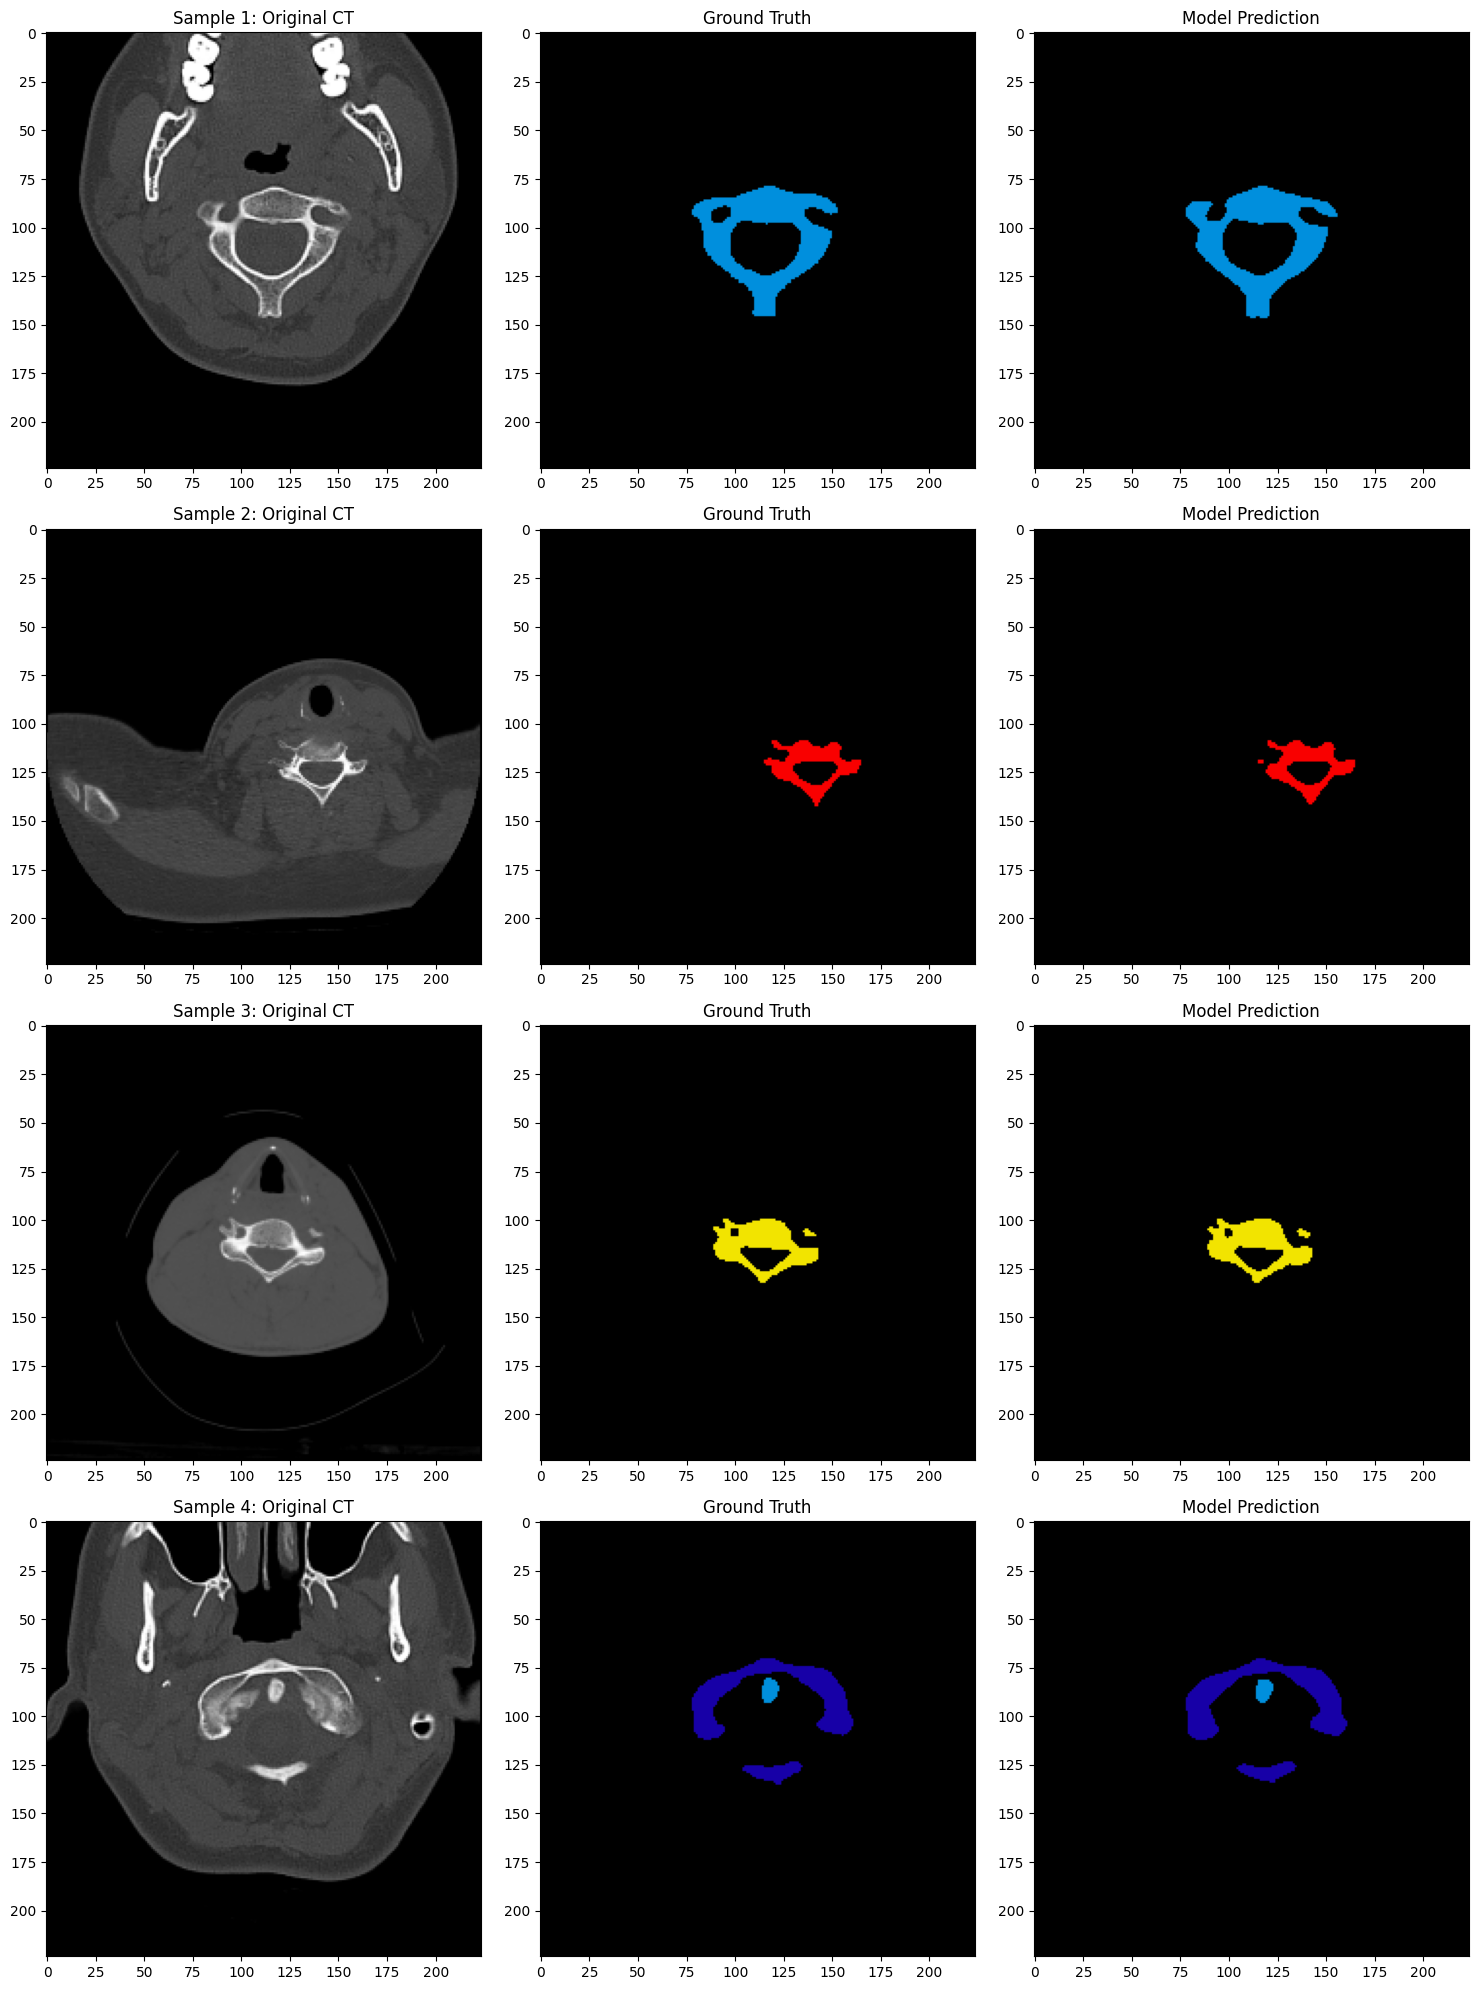

In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from step3_dataset import CervicalDataset, get_transforms
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
import os

# 1. 설정 (학습 코드와 동일하게)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_PATH = './checkpoints/best_model.pth'
DATA_DIR = 'final_preprocessed'

# 2. 모델 및 데이터 로더 준비
model = smp.Unet(encoder_name="resnet34", in_channels=2, classes=8).to(DEVICE)

if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    print("✅ 저장된 최적 모델을 성공적으로 불러왔습니다!")
else:
    print("❌ 아직 저장된 모델 파일이 없습니다. 학습이 최소 1에폭은 끝나야 합니다!")

val_ds = CervicalDataset('val_patients.txt', DATA_DIR, transform=get_transforms('val'))
val_loader = DataLoader(val_ds, batch_size=4, shuffle=True) # 4장만 무작위로 확인

# 3. 추론 및 시각화
model.eval()
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1) # 8개 채널 중 가장 확률 높은 클래스 선택
        break # 첫 번째 배치만 확인

# 4. 결과 출력
imgs = imgs.cpu().numpy()
masks = masks.cpu().numpy()
preds = preds.cpu().numpy()

fig, axes = plt.subplots(4, 3, figsize=(15, 20)) # 4개 샘플 확인
for i in range(4):
    # 원본 CT (0번 채널)
    axes[i, 0].imshow(imgs[i, 0], cmap='gray')
    axes[i, 0].set_title(f"Sample {i+1}: Original CT")
    
    # 정답 마스크
    axes[i, 1].imshow(masks[i], cmap='nipy_spectral', vmin=0, vmax=7)
    axes[i, 1].set_title("Ground Truth")
    
    # 모델 예측
    axes[i, 2].imshow(preds[i], cmap='nipy_spectral', vmin=0, vmax=7)
    axes[i, 2].set_title("Model Prediction")

plt.tight_layout()
plt.show()